In [17]:
import pandas as pd
import numpy as np
import os
import time
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [18]:
base_path = os.path.dirname(os.path.dirname(os.getcwd()))
data_path = os.path.join(base_path, "data", "processed", "diplomacy")
model_dir = os.path.join(base_path, "models") # model_dir tanımlandı
model_path = os.path.join(model_dir, 'lstm_diplomacy.h5')
results_file = os.path.join(base_path, "reports", "model_results_deceptency_lstm.csv")

os.makedirs(model_dir, exist_ok=True)
os.makedirs(os.path.dirname(results_file), exist_ok=True)

In [19]:
# Load Data
train_df = pd.read_parquet(os.path.join(data_path, "train_processed.parquet"))
val_df = pd.read_parquet(os.path.join(data_path, "val_processed.parquet"))
test_df = pd.read_parquet(os.path.join(data_path, "test_processed.parquet"))

print(f"Train shape: {train_df.shape}")
print(f"Val shape: {val_df.shape}")
print(f"Test shape: {test_df.shape}")

y_train = train_df['target'].values
y_val = val_df['target'].values
y_test = test_df['target'].values

Train shape: (13132, 13)
Val shape: (1416, 13)
Test shape: (2741, 13)


In [20]:
skip_training = False
training_time_minutes = 0

if os.path.exists(model_path):
    print(f'Model bulundu: {model_path}. Yükleniyor...')
    model = load_model(model_path)
    skip_training = True
else:
    print('Model bulunamadı. Yeni model eğitilecek.')

Model bulunamadı. Yeni model eğitilecek.


In [21]:
VOCAB_SIZE = 10000
MAX_LEN = 150
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['message_text'])

In [22]:
X_train = pad_sequences(tokenizer.texts_to_sequences(train_df['message_text']), maxlen=MAX_LEN, padding='post')
X_val = pad_sequences(tokenizer.texts_to_sequences(val_df['message_text']), maxlen=MAX_LEN, padding='post')
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df['message_text']), maxlen=MAX_LEN, padding='post')

In [23]:
if not skip_training:
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = dict(enumerate(class_weights))

    model = Sequential([
        Embedding(VOCAB_SIZE, 100, input_length=MAX_LEN),
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(32)),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.0001)

    start_time = time.time()
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val),
              class_weight=class_weights_dict, callbacks=[early_stopping, reduce_lr])
    training_time_minutes = (time.time() - start_time) / 60
    
    model.save(model_path)
    print(f"Model kaydedildi: {model_path}")

Epoch 1/20


c:\Users\Aybars\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


411/411 ━━━━━━━━━━━━━━━━━━━━ 40s 82ms/step - accuracy: 0.6902 - loss: 0.6776 - val_accuracy: 0.7719 - val_loss: 0.6264 - learning_rate: 0.0010
Epoch 2/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 30s 73ms/step - accuracy: 0.7639 - loss: 0.5894 - val_accuracy: 0.7980 - val_loss: 0.6036 - learning_rate: 0.0010
Epoch 3/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 39s 96ms/step - accuracy: 0.8063 - loss: 0.4564 - val_accuracy: 0.8008 - val_loss: 0.4620 - learning_rate: 0.0010
Epoch 4/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 40s 97ms/step - accuracy: 0.8100 - loss: 0.3740 - val_accuracy: 0.7895 - val_loss: 0.4579 - learning_rate: 0.0010
Epoch 5/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 36s 89ms/step - accuracy: 0.8509 - loss: 0.2838 - val_accuracy: 0.7415 - val_loss: 0.5854 - learning_rate: 0.0010
Epoch 6/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 28s 69ms/step - accuracy: 0.8839 - loss: 0.2147 - val_accuracy: 0.8037 - val_loss: 0.5128 - learning_rate: 5.0000e-04
Epoch 7/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 27s 66ms/step - accuracy: 0.9160 - loss: 0.

Model kaydedildi: c:\work environment\Projects\amazon-spam-review\models\lstm_diplomacy.h5


In [24]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
report = classification_report(y_test, y_pred, target_names=['Truth', 'Deception'], output_dict=True)

print("\n--- TEST SONUÇLARI ---")
print(classification_report(y_test, y_pred, target_names=['Truth', 'Deception']))

86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step

--- TEST SONUÇLARI ---
              precision    recall  f1-score   support

       Truth       0.92      0.78      0.84      2501
   Deception       0.12      0.31      0.17       240

    accuracy                           0.74      2741
   macro avg       0.52      0.54      0.51      2741
weighted avg       0.85      0.74      0.78      2741



Sonuçlar kaydedildi: c:\work environment\Projects\amazon-spam-review\reports\model_results_deceptency_lstm.csv


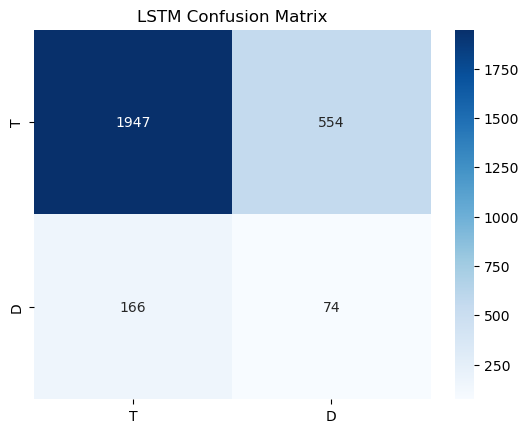

In [25]:
result_data = {
    'category': 'Deceptency_LSTM',
    'test_accuracy': report['accuracy'],
    'test_f1_truth': report['Truth']['f1-score'],
    'test_f1_deception': report['Deception']['f1-score'],
    'training_time_minutes': training_time_minutes
}
results_file = os.path.join(base_path, "reports", "model_results_deceptency_lstm.csv")
pd.DataFrame([result_data]).to_csv(results_file, mode='a', header=not os.path.exists(results_file), index=False)
print(f"Sonuçlar kaydedildi: {results_file}")

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['T', 'D'], yticklabels=['T', 'D'])
plt.title('LSTM Confusion Matrix')
plt.show()